# Atmospheric composition distribution by CAMS and TROPOMI

### Main goal:
* Compare TROPOMI and CAMS datasets for NO<sub>2</sub>, CO, O<sub>3</sub> and SO<sub>2</sub> (Level 2).

## Imports and supporting functions

In [1]:
import os 
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
import datetime as dt
import geocoder
import seaborn as sns
from matplotlib.cbook import boxplot_stats  

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_tropomi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define datasets

In [4]:
# Define component
component_nom = 'NO2'

# Define sensor
sensor = 'tropomi'
sensor_type = 'L2'

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom)

# Folders generation
generate_folders(model, sensor, component_nom)

The comparison is possible and will start now.


In [5]:
# Define extent
lon_min = 12
lon_max = 18.9
lat_min = 48.5
lat_max = 51.1

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

# Define search period
start_date = '2021-08-21'
end_date = '2021-08-22'
dates = search_period(start_date, end_date, sensor, sensor_type)

SEARCH PERIOD
- In days: [('2021-08-21T00:00:00Z', '2021-08-21T23:00:00Z'), ('2021-08-22T00:00:00Z', '2021-08-22T23:00:00Z')]


## 2. Model data

### Download and read data as xarray

In [6]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, 
                                               component_nom, model_full_name, model_level = 'Multiple')

2021-09-19 12:33:17,878 INFO Welcome to the CDS
2021-09-19 12:33:17,878 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2021-09-19 12:33:18,003 INFO Request is completed
2021-09-19 12:33:18,004 INFO Downloading https://download-0002.copernicus-atmosphere.eu/cache-compute-0002/cache/data3/adaptor.mars_constrained.internal-1630770548.8187523-32361-2-9232657c-cdb4-45bf-bb39-20adac4016aa.grib to data/cams/NO2/NO2-hourly-levels-2021-08-21-2021-08-22.grib (1.2G)


The file does not exist, it will be downloaded.


2021-09-19 12:33:41,241 INFO Download rate 54.8M/s


In [7]:
model_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 451, longitude: 900, step: 4, time: 2)
Coordinates:
  * time        (time) datetime64[ns] 2021-08-21 2021-08-22
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 -88.8 ... 89.2 89.6 90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, hybrid, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-19T12:33 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [8]:
model_levels_df = CAMS_137_levels()
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],ph-diff [Pa],Depth [m]
hybrid,,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,1.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,1.57,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2.16,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2.92,2320.96
...,...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,341.69,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,313.12,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,286.77,22.96


### Convert CAMS data units (kg/kg to molecules/cm<sup>2</sup>)

In [9]:
model_ds, units = model_convert_units(model_ds, model, component_mol_weight, component, conversion_method = 'Simple')

The model component units have been converted from kg kg**-1 to kg m**-2.
The model component units have been converted from kg m**-2 to molec cm-2.


### Download read and subset original total columns data

In [10]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single')
model_total_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_total_ds = subset(model_total_ds, bbox)
model_total_ds

2021-09-19 12:34:01,731 INFO Welcome to the CDS
2021-09-19 12:34:01,732 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2021-09-19 12:34:01,794 INFO Request is completed
2021-09-19 12:34:01,795 INFO Downloading https://download-0003.copernicus-atmosphere.eu/cache-compute-0003/cache/data6/adaptor.mars_constrained.internal-1630770595.495475-3722-16-3b372f98-3aed-4623-bc2e-d444619062ae.grib to data/cams/NO2/NO2-hourly-tc-2021-08-21-2021-08-22.grib (9.3M)


The file does not exist, it will be downloaded.


2021-09-19 12:34:02,017 INFO Download rate 41.9M/s


<xarray.Dataset>
Dimensions:     (latitude: 8, longitude: 18, step: 4, time: 2)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2021-08-21 2021-08-22
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
    surface     float64 ...
  * latitude    (latitude) float64 48.4 48.8 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 ... 17.6 18.0 18.4 18.8
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-19T12:34 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS total columns data units (kg/m2 to molecules/cm<sup>2</sup>)

In [11]:
model_total_ds, _ = model_convert_units(model_total_ds, model, component_mol_weight, component, conversion_method = 'Simple')

The model component units have been converted from kg m**-2 to molec cm-2.


## 3. Sensor data

### Download and read data as xarray

In [12]:
sensor_product_names = sensor_download(sensor, sensor_type, component_nom, bbox, dates, product_type)

You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-09-19 12:34:03,176 INFO Found 1 products


RESULTS FOR PERIOD ('2021-08-21T00:00:00Z', '2021-08-21T23:00:00Z')
Number 0-S5P_NRTI_L2__NO2____20210821T115635_20210821T120135_19977_02_020200_20210821T130021


2021-09-19 12:34:05,634 INFO Downloading 3c0cad64-2a3b-497d-be7a-deab77ab7ac8 to data/tropomi/NO2/S5P_NRTI_L2__NO2____20210821T115635_20210821T120135_19977_02_020200_20210821T130021.nc


SELECTED
File name: 3c0cad64-2a3b-497d-be7a-deab77ab7ac8
Product name: S5P_NRTI_L2__NO2____20210821T115635_20210821T120135_19977_02_020200_20210821T130021.nc
The file does not exist, it will be downloaded.


Downloading:   0%|          | 0.00/62.3M [00:00<?, ?B/s]

MD5 checksumming:   0%|          | 0.00/62.3M [00:00<?, ?B/s]

You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-09-19 12:34:08,398 INFO Found 1 products


RESULTS FOR PERIOD ('2021-08-22T00:00:00Z', '2021-08-22T23:00:00Z')
Number 0-S5P_NRTI_L2__NO2____20210822T113635_20210822T114135_19991_02_020200_20210822T124046
SELECTED
File name: 47fefdcb-c0b0-4090-afa2-d713dc2357c5
Product name: S5P_NRTI_L2__NO2____20210822T113635_20210822T114135_19991_02_020200_20210822T124046.nc
The file does not exist, it will be downloaded.


2021-09-19 12:34:35,197 INFO Downloading 47fefdcb-c0b0-4090-afa2-d713dc2357c5 to data/tropomi/NO2/S5P_NRTI_L2__NO2____20210822T113635_20210822T114135_19991_02_020200_20210822T124046.nc


Downloading:   0%|          | 0.00/61.9M [00:00<?, ?B/s]

MD5 checksumming:   0%|          | 0.00/61.9M [00:00<?, ?B/s]

In [13]:
sensor_ds, support_input_ds, support_details_ds = sensor_read(sensor, sensor_type, component_nom, sensor_product_names)
sensor_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 2, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column                   (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...

### Convert TROPOMI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [14]:
sensor_ds = sensor_convert_units(sensor_ds, sensor_column, sensor, component)
sensor_ds

The sensor component units have been converted from mol cm-2 to molec cm-2.


<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 2, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column                   (time, scanline, ground_pixel) float64 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...

## 4. Match data (and apply averaging kernels)

In [15]:
kernels_method = None # None, Interpolation or Nearest neighbours
match_table = generate_match_table(sensor_ds, model_ds, bbox, kernels_method, 
                                   sensor, component_nom, sensor_column, model_levels_df)
match_table

The layers pressures will be calculated (lower and upper bounds).
The dataset does not contain any apriori profile.
FOR EST. TIME: 2021-08-21T00:00:00.000000000
The dataset does not contain data to apply the averaging kernels.
The partial columns will be sumed up.
The sum will be matched to the sensor data by nearest neighbours.
FOR EST. TIME: 2021-08-22T00:00:00.000000000
The dataset does not contain data to apply the averaging kernels.
The partial columns will be sumed up.
The sum will be matched to the sensor data by nearest neighbours.


delta_time   latitude  \
scanline ground_pixel time       layer                                      
166.0    210.0        2021-08-21 0.0   2021-08-21 11:58:49.210  47.614220   
         211.0        2021-08-21 0.0   2021-08-21 11:58:49.210  47.623695   
         212.0        2021-08-21 0.0   2021-08-21 11:58:49.210  47.633114   
         213.0        2021-08-21 0.0   2021-08-21 11:58:49.210  47.642490   
         214.0        2021-08-21 0.0   2021-08-21 11:58:49.210  47.651817   
...                                                        ...        ...   
322.0    267.0        2021-08-22 33.0  2021-08-22 11:41:00.645  52.308796   
         268.0        2021-08-22 33.0  2021-08-22 11:41:00.645  52.316521   
         269.0        2021-08-22 33.0  2021-08-22 11:41:00.645  52.324215   
         270.0        2021-08-22 33.0  2021-08-22 11:41:00.645  52.331882   
         271.0        2021-08-22 33.0  2021-08-22 11:41:00.645  52.339504   

                                        longitude  qa_value  \
scanline ground_pixel time       layer                        
166.0    210.0        2021-08-21 0.0    12.400394      1.00   
         211.0        2021-08-21 0.0    12.446804      1.00   
         212.0        2021-08-21 0.0    12.493212      1.00   
         213.0        2021-08-21 0.0    12.539618      1.00   
         214.0        2021-08-21 0.0    12.586019      1.00   
...                                           ...       ...   
322.0    267.0        2021-08-22 33.0   18.153767      0.74   
         268.0        2021-08-22 33.0   18.207802      0.74   
         269.0        2021-08-22 33.0   18.261974      0.74   
         270.0        2021-08-22 33.0   18.316290      0.74   
         271.0        2021-08-22 33.0   18.370750      0.74   

                                        nitrogendioxide_tropospheric_column  \
scanline ground_pixel time       layer                                        
166.0    210.0        2021-08-21 0.0                           9.012096e+14   
         211.0        2021-08-21 0.0                           3.852566e+14   
         212.0        2021-08-21 0.0                          -5.914256e+13   
         213.0        2021-08-21 0.0                           4.147927e+14   
         214.0        2021-08-21 0.0                           1.057038e+13   
...                                                                     ...   
322.0    267.0        2021-08-22 33.0                          3.619039e+15   
         268.0        2021-08-22 33.0                          3.041250e+15   
         269.0        2021-08-22 33.0                          3.948965e+15   
         270.0        2021-08-22 33.0                          2.909086e+15   
         271.0        2021-08-22 33.0                          2.206202e+15   

                                        nitrogendioxide_tropospheric_column_precision  \
scanline ground_pixel time       layer                                                  
166.0    210.0        2021-08-21 0.0                                         0.000010   
         211.0        2021-08-21 0.0                                         0.000011   
         212.0        2021-08-21 0.0                                         0.000011   
         213.0        2021-08-21 0.0                                         0.000011   
         214.0        2021-08-21 0.0                                         0.000012   
...                                                                               ...   
322.0    267.0        2021-08-22 33.0                                        0.000026   
         268.0        2021-08-22 33.0                                        0.000024   
         269.0        2021-08-22 33.0                                        0.000026   
         270.0        2021-08-22 33.0                                        0.000024   
         271.0        2021-08-22 33.0                                        0.000020   

                                        nitr

## 5. Merge data and calculate difference

In [16]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, kernels_method, sensor_column, sensor)
merge_table

latitude  longitude  model_column  \
scanline ground_pixel time                                             
166.0    210.0        2021-08-21  47.614223  12.400394  2.320369e+15   
         211.0        2021-08-21  47.623692  12.446804  2.320369e+15   
         212.0        2021-08-21  47.633110  12.493213  2.320369e+15   
         213.0        2021-08-21  47.642487  12.539618  2.320369e+15   
         214.0        2021-08-21  47.651821  12.586020  2.320369e+15   
...                                     ...        ...           ...   
322.0    267.0        2021-08-22  52.308800  18.153765  3.353601e+15   
         268.0        2021-08-22  52.316521  18.207804  3.451539e+15   
         269.0        2021-08-22  52.324215  18.261974  3.451539e+15   
         270.0        2021-08-22  52.331882  18.316290  3.451539e+15   
         271.0        2021-08-22  52.339504  18.370749  3.451539e+15   

                                  nitrogendioxide_tropospheric_column  \
scanline ground_pixel time                                              
166.0    210.0        2021-08-21                         9.012096e+14   
         211.0        2021-08-21                         3.852566e+14   
         212.0        2021-08-21                        -5.914256e+13   
         213.0        2021-08-21                         4.147927e+14   
         214.0        2021-08-21                         1.057038e+13   
...                                                               ...   
322.0    267.0        2021-08-22                         3.619039e+15   
         268.0        2021-08-22                         3.041250e+15   
         269.0        2021-08-22                         3.948965e+15   
         270.0        2021-08-22                         2.909086e+15   
         271.0        2021-08-22                         2.206202e+15   

                                    difference  
scanline ground_pixel time                      
166.0    210.0        2021-08-21 -1.419160e+15  
         211.0        2021-08-21 -1.935113e+15  
         212.0        2021-08-21 -2.379512e+15  
         213.0        2021-08-21 -1.905577e+15  
         214.0        2021-08-21 -2.309799e+15  
...                                        ...  
322.0    267.0        2021-08-22  2.654382e+14  
         268.0        2021-08-22 -4.102892e+14  
         269.0        2021-08-22  4.974258e+14  
         270.0        2021-08-22 -5.424532e+14  
         271.0        2021-08-22 -1.245337e+15  

[20268 rows x 5 columns]

In [17]:
descr_statistics_table = merge_table.describe()
descr_statistics_table

,latitude,longitude,model_column,nitrogendioxide_tropospheric_column,difference
count,20268.000000,20268.000000,2.026800e+04,1.992300e+04,1.992300e+04
mean,49.805161,15.344185,3.092187e+15,1.685491e+15,-1.370161e+15
std,1.080871,2.163737,9.938733e+14,1.214709e+15,1.193946e+15
min,47.155933,10.796742,1.973010e+15,-1.289277e+15,-7.578685e+15
25%,48.930606,13.530818,2.403847e+15,9.216067e+14,-2.025449e+15
50%,49.802217,15.312210,2.805137e+15,1.458558e+15,-1.389241e+15
75%,50.672780,17.153953,3.414964e+15,2.156744e+15,-7.370889e+14
max,52.339504,19.837698,8.751839e+15,1.364439e+16,1.060183e+16


## 6. Show comparison plots

### Select plot dates

In [19]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2021-08-21T00:00:00.000000000' '2021-08-22T00:00:00.000000000']


### Select plot extent

In [20]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((12, 48.5), (18.9, 51.1))


### Compare CAMS and TROPOMI total columns

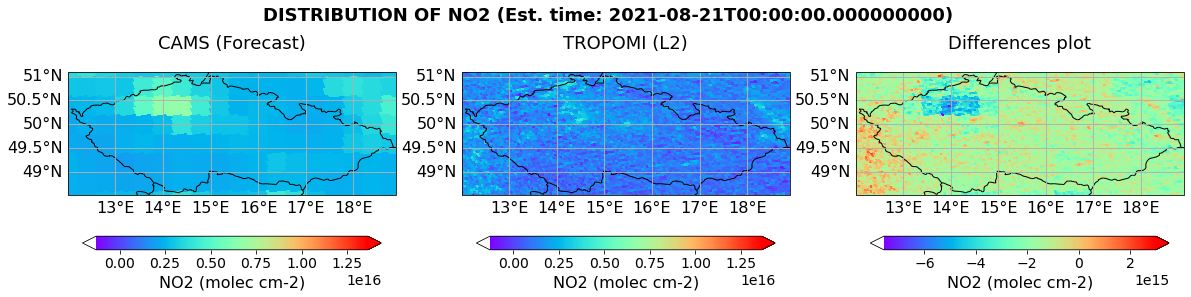

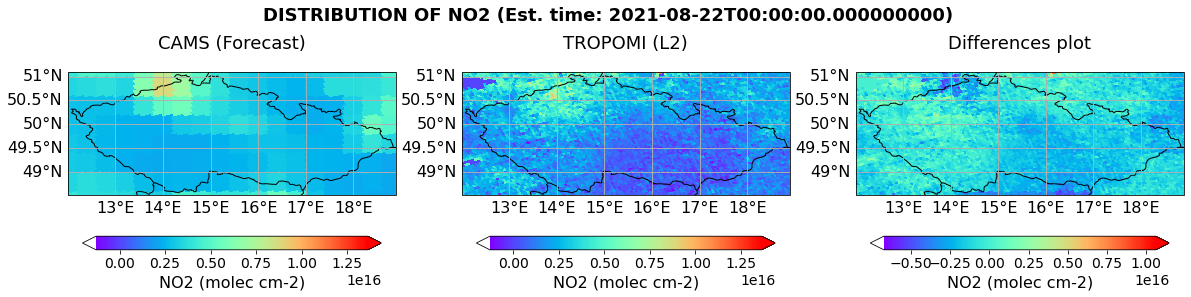

In [32]:
# Choose distribution (aggregated or individual)
distribution_type = 'individual'

# Choose range (original, equal or manual)
range_type = 'equal'
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'rainbow'

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, plot_bbox, 20, 0.80, 
                          model_type, sensor_type, range_type, sensor_column, distribution_type, projection,
                          color_scale, vmin_manual, vmax_manual)

### Compare CAMS original and averaged total columns

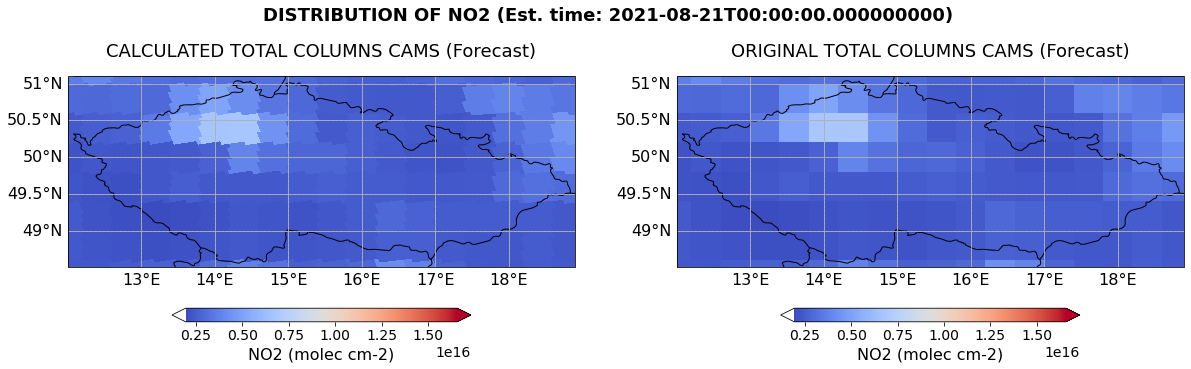

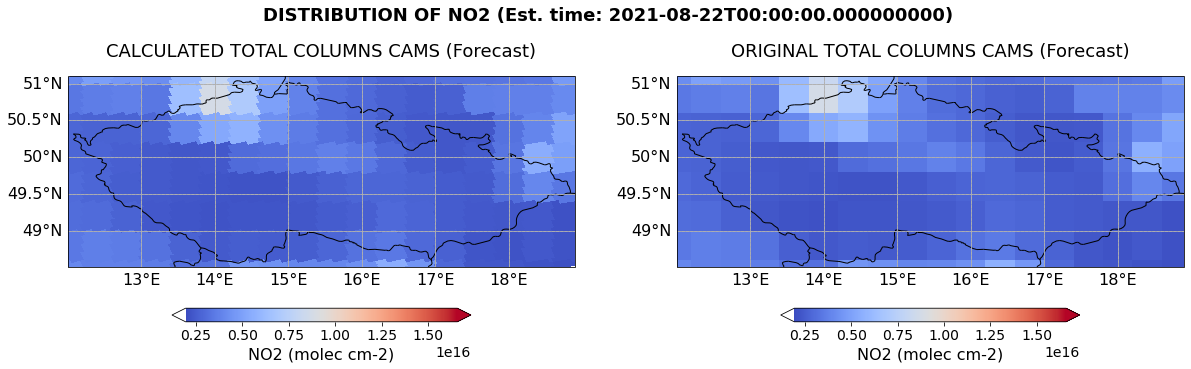

In [22]:
range_type = 'equal' # original or equal

projection = ccrs.PlateCarree()
color_scale = 'coolwarm' 

visualize_model_original_vs_calculated(model, component_nom,units, merge_table, model_total_ds, plot_dates, 
                                       plot_bbox, 20, 1, model_type, range_type, projection, color_scale)

## 7. Retrieve nearest values to specific latitude and longitude

In [23]:
coords_search_list = (50, 60,
                      4, 10,
                      20, 30)
retrieval_table_all =  retrieve_coords(merge_table.dropna(), coords_search_list, component_nom, 
                                       sensor_column, sensor, model, plot_dates, units)
retrieval_table_all

scanline  ground_pixel  \
lat_search lon_search latitude  longitude time                                 
50         60         48.560848 19.600424 2021-08-21     166.0         345.0   
                      48.699471 19.837698 2021-08-22     247.0         271.0   
4          10         47.614223 12.400394 2021-08-21     166.0         210.0   
                      47.155933 12.771409 2021-08-22     247.0         127.0   
20         30         48.560848 19.600424 2021-08-21     166.0         345.0   
                      48.699471 19.837698 2021-08-22     247.0         271.0   

                                                      model_column  \
lat_search lon_search latitude  longitude time                       
50         60         48.560848 19.600424 2021-08-21  2.441548e+15   
                      48.699471 19.837698 2021-08-22  2.188035e+15   
4          10         47.614223 12.400394 2021-08-21  2.320369e+15   
                      47.155933 12.771409 2021-08-22  3.714675e+15   
20         30         48.560848 19.600424 2021-08-21  2.441548e+15   
                      48.699471 19.837698 2021-08-22  2.188035e+15   

                                                      nitrogendioxide_tropospheric_column  \
lat_search lon_search latitude  longitude time                                              
50         60         48.560848 19.600424 2021-08-21                         9.540122e+14   
                      48.699471 19.837698 2021-08-22                         6.709503e+14   
4          10         47.614223 12.400394 2021-08-21                         9.012096e+14   
                      47.155933 12.771409 2021-08-22                         3.028209e+14   
20         30         48.560848 19.600424 2021-08-21                         9.540122e+14   
                      48.699471 19.837698 2021-08-22                         6.709503e+14   

                                                        difference  
lat_search lon_search latitude  longitude time                      
50         60         48.560848 19.600424 2021-08-21 -1.487536e+15  
                      48.699471 19.837698 2021-08-22 -1.517085e+15  
4          10         47.614223 12.400394 2021-08-21 -1.419160e+15  
                      47.155933 12.771409 2021-08-22 -3.411854e+15  
20         30         48.560848 19.600424 2021-08-21 -1.487536e+15  
                      48.699471 19.837698 2021-08-22 -1.517085e+15

## 8. Scatter plots by bbox

Fit equation: NO2_model = NO2_sensor * 0.31 + (2.53E+15)
Coefficient of determination (R2): 0.17


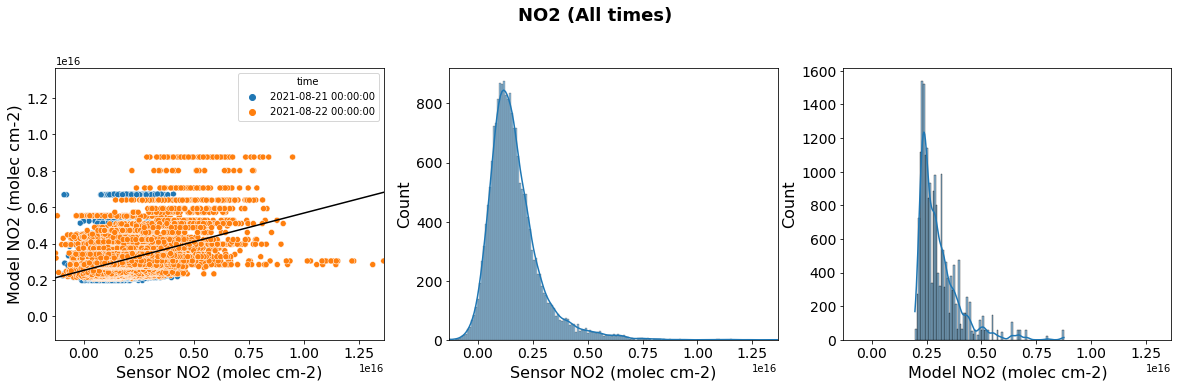

In [24]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1.05, extent_definition, show_seasons, scatter_plot_type, plot_bbox)

In [25]:
summary

,Period,Location,Score,Coefficient,Intercept
0,"[2021-08-21T00:00:00.000000000, 2021-08-22T00:...","((12, 48.5), (18.9, 51.1))",0.166121,0.31433,2.525853e+15


## 9. Scatter plots by season

Fit equation: NO2_model = NO2_sensor * 0.31 + (2.53E+15)
Coefficient of determination (R2): 0.17


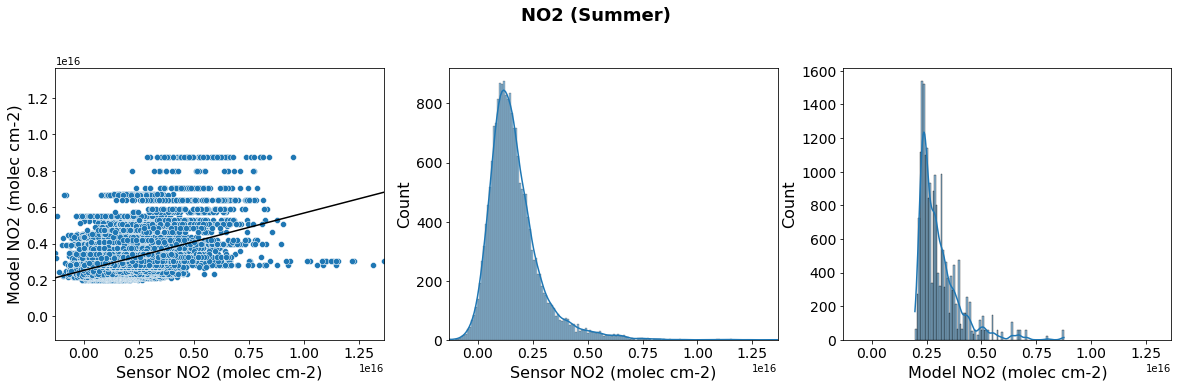

In [26]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1.05, extent_definition, show_seasons, scatter_plot_type, plot_bbox)

In [27]:
summary

,Period,Location,Score,Coefficient,Intercept
0,Summer,"((12, 48.5), (18.9, 51.1))",0.166121,0.31433,2.525853e+15


## 10. Scatter plots by country (Google API required!)

In [28]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
plot_countries = ['Czech Republic', 'Poland', 'Germany']
scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
             plot_dates, 1.05, extent_definition, show_seasons, scatter_plot_type, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'aggregated' # aggregated or individual\nplot_countries = ['Czech Republic', 'Poland', 'Germany']\nscatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, \n             plot_dates, 1.05, extent_definition, show_seasons, scatter_plot_type, plot_countries)\n"

In [29]:
#summary